# Yelp Restaurant Sucesss

# Agenda
- ### Problem Stattement
    - #### Understanding the factors that influence business success is crucial for stakeholders.
- ### Research Objectives
   - #### Quantify the coorelation between user engagement (reviews, tips, check_ins) and review count / average star rating.
   - #### Analyze the impact of sentiment on review count and average star rating.
   - #### Time Trends in User Engagement.
- ### Hypothesis testing
   - #### Higher levels of user engagement coorelate with higher review counts and ratings for restaurants.
   - #### Positive sentiment expressed in reviews and tips contributes to higher overall ratings and review counts for restaurants.
   - #### Consistent engagement over time is postively associated with sustained business success for restaurants.
- ### Data Overview
- ### Analysis and findings
- ### Recommendations

# Importing Dependencies

In [1]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt, seaborn as sns, sqlite3, folium
from datetime import datetime
from geopy.geocoders import Nominatim
from matplotlib.colors import LinearSegmentedColormap
from IPython.display import display

import warnings
warnings.filterwarnings('ignore')

sns.set_style('whitegrid')
plt.style.use('ggplot')

# Database Connection

In [2]:
conn = sqlite3.connect('yelp.db')

In [3]:
tables = pd.read_sql_query("SELECT name from sqlite_master where type = 'table'", conn)

In [4]:
tables

,name
0,business
1,checkin
2,tip
3,review
4,user


## All table Data

In [5]:
for table in tables['name']:
    print(' ')
    print(table)
    display(pd.read_sql_query(f"select * from {table} LIMIT 2", conn))
    print('_________________________________')

 
business


,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,categories
0,Pns2l4eNsfO8kk83dixA6A,"Abby Rappoport, LAC, CMQ","1616 Chapala St, Ste 2",Santa Barbara,CA,93101,34.426679,-119.711197,5.0,7,0,"Doctors, Traditional Chinese Medicine, Naturop..."
1,mpf3x-BjTdTEA3yCZrAYPw,The UPS Store,87 Grasso Plaza Shopping Center,Affton,MO,63123,38.551126,-90.335695,3.0,15,1,"Shipping Centers, Local Services, Notaries, Ma..."


_________________________________
 
checkin


,business_id,date
0,---kPU91CF4Lq2-WlRu9Lw,"2020-03-13 21:10:56, 2020-06-02 22:18:06, 2020..."
1,--0iUa4sNDFiZFrAdIWhZQ,"2010-09-13 21:43:09, 2011-05-04 23:08:15, 2011..."


_________________________________
 
tip


,user_id,business_id,text,date,compliment_count
0,AGNUgVwnZUey3gcPCJ76iw,3uLgwr0qeCNMjKenHJwPGQ,Avengers time with the ladies.,2012-05-18 02:17:21,0
1,NBN4MgHP9D3cw--SnauTkA,QoezRbYQncpRqyrLH6Iqjg,They have lots of good deserts and tasty cuban...,2013-02-05 18:35:10,0


_________________________________
 
review


,review_id,user_id,business_id,stars,useful,funny,cool,text,date
0,Xvl1ywjwdKL63Im2V-zXFw,Rh1jG5ufIFQmbBCIPScGZA,5YkucjpFYEhg4gsWU4B1hQ,5,0,0,0,The best diner in center city! RIP Little Pete's,2017-08-31 19:14:02.000000
1,md77V2gKIdZ_0SKCdnvomw,Fr-frpXBhY0okrgQ0olxeg,t6gAgrvNQDHHvyhBXUDFrQ,5,0,0,0,Best place to have cocktails and watch the sun...,2012-10-26 00:17:28.000000


_________________________________
 
user


,user_id,name,review_count,yelping_since,useful,funny,cool,elite,friends,fans,...,compliment_more,compliment_profile,compliment_cute,compliment_list,compliment_note,compliment_plain,compliment_cool,compliment_funny,compliment_writer,compliment_photos
0,qVc8ODYU5SZjKXVBgXdI7w,Walker,585,2007-01-25 16:47:26,7217,1259,5994,2007,"NSCy54eWehBJyZdG2iE84w, pe42u7DcCH2QmI81NX-8qA...",267,...,65,55,56,18,232,844,467,467,239,180
1,j14WgRoU_-2ZE1aw1dXrJg,Daniel,4333,2009-01-25 04:35:42,43091,13066,27281,"2009,2010,2011,2012,2013,2014,2015,2016,2017,2...","ueRPE0CX75ePGMqOFVj6IQ, 52oH4DrRvzzl8wh5UXyU0A...",3138,...,264,184,157,251,1847,7054,3131,3131,1521,1946


_________________________________


# EDA

In [6]:
pd.read_sql_query('select count(*) from business', conn)

,count(*)
0,150346


In [7]:
business_id = pd.read_sql_query(""" select business_id, review_count from business where lower(categories) like '%restaurant%' and is_open = 1""", conn)

### Descriptive statistics

In [8]:
desc = pd.read_sql_query(f"""SELECT
    AVG(review_count) AS mean,MIN(review_count) as min ,MAX(review_count) as max,
    (SELECT review_count FROM business ORDER BY review_count LIMIT 1 OFFSET (SELECT COUNT(*) FROM business)/2) AS median,
    
    avg(stars), min(stars), max(stars),
    (select stars from business order by stars limit 1 offset (select count(*) from business)/2) as median_stars
    
    FROM business
    WHERE business_id IN {tuple(business_id['business_id'])}
""", conn)
desc.transpose()

,0
mean,104.097789
min,5.000000
max,7568.000000
median,15.000000
avg(stars),3.523969
min(stars),1.000000
max(stars),5.000000
median_stars,3.500000


In [9]:
df = pd.read_sql_query(f"select * from business where business_id IN {tuple(business_id['business_id'])}", conn)

In [10]:
df

,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,categories
0,MTSW4McQd7CbVtyjqoe9mw,St Honore Pastries,935 Race St,Philadelphia,PA,19107,39.955505,-75.155564,4.0,80,1,"Restaurants, Food, Bubble Tea, Coffee & Tea, B..."
1,CF33F8-E6oudUQ46HnavjQ,Sonic Drive-In,615 S Main St,Ashland City,TN,37015,36.269593,-87.058943,2.0,6,1,"Burgers, Fast Food, Sandwiches, Food, Ice Crea..."
2,bBDDEgkFA1Otx9Lfe7BZUQ,Sonic Drive-In,2312 Dickerson Pike,Nashville,TN,37207,36.208102,-86.768170,1.5,10,1,"Ice Cream & Frozen Yogurt, Fast Food, Burgers,..."
3,eEOYSgkmpB90uNA7lDOMRA,Vietnamese Food Truck,,Tampa Bay,FL,33602,27.955269,-82.456320,4.0,10,1,"Vietnamese, Food, Restaurants, Food Trucks"
4,il_Ro8jwPlHresjw9EGmBg,Denny's,8901 US 31 S,Indianapolis,IN,46227,39.637133,-86.127217,2.5,28,1,"American (Traditional), Restaurants, Diners, B..."
...,...,...,...,...,...,...,...,...,...,...,...,...
34999,w_4xUt-1AyY2ZwKtnjW0Xg,Bittercreek Alehouse,246 N 8th St,Boise,ID,83702,43.616590,-116.202383,4.5,998,1,"Bars, Gastropubs, Sandwiches, Nightlife, Resta..."
35000,l9eLGG9ZKpLJzboZq-9LRQ,Wawa,19 N Bishop Ave,Clifton Heights,PA,19018,39.925656,-75.310344,3.0,11,1,"Restaurants, Sandwiches, Convenience Stores, C..."
35001,cM6V90ExQD6KMSU3rRB5ZA,Dutch Bros Coffee,1181 N Milwaukee St,Boise,ID,83704,43.615401,-116.284689,4.0,33,1,"Cafes, Juice Bars & Smoothies, Coffee & Tea, R..."
35002,WnT9NIzQgLlILjPT0kEcsQ,Adelita Taqueria & Restaurant,1108 S 9th St,Philadelphia,PA,19147,39.935982,-75.158665,4.5,35,1,"Restaurants, Mexican"


In [11]:
def cape_outliers(df, col):
    df = df.copy()
    q3 = df[col].quantile(0.75)
    q1 = df[col].quantile(0.25)
    iqr = q3 - q1

    lower = q1 - (1.5*iqr)
    upper = q3 + (1.5*iqr)

    df[col] = np.where(
        df[col]>upper,upper,
        np.where(df[col]<lower, lower, df[col]))

    return df

In [12]:
business_id = cape_outliers(business_id,'review_count')

In [13]:
business_id.describe()

,review_count
count,35004.000000
mean,75.044181
std,78.675421
min,5.000000
25%,16.000000
50%,40.000000
75%,109.000000
max,248.500000


### Restuarant with highest review

In [14]:
pd.read_sql_query(f'''SELECT name, sum(review_count) as review_count, avg(stars) as avg_rating from business WHERE business_id in {tuple(business_id['business_id'])}
group by name order by review_count DESC LIMIT 10''', conn)

,name,review_count,avg_rating
0,McDonald's,16490,1.868702
1,Chipotle Mexican Grill,9071,2.381757
2,First Watch,8688,3.896552
3,Acme Oyster House,8343,4.000000
4,Taco Bell,8017,2.141813
5,Chick-fil-A,7943,3.381410
6,Oceana Grill,7400,4.000000
7,Buffalo Wild Wings,6810,2.347458
8,Panera Bread,6613,2.661905
9,Hattie B’s Hot Chicken - Nashville,6093,4.500000


### Restuarant with highest review

In [15]:
pd.read_sql_query('''select business_id, sum(length(date) - length(replace(date,',',''))+1) as checkin_count from checkin group by business_id''', conn)

,business_id,checkin_count
0,---kPU91CF4Lq2-WlRu9Lw,11
1,--0iUa4sNDFiZFrAdIWhZQ,10
2,--30_8IhuyMHbSOcNWd6DQ,2
3,--7PUidqRWpRSpXebiyxTg,10
4,--7jw19RH9JKXgFohspgQw,26
...,...,...
131925,zznJox6-nmXlGYNWgTDwQQ,67
131926,zznZqH9CiAznbkV6fXyHWA,1
131927,zzu6_r3DxBJuXcjnOYVdTw,23
131928,zzw66H6hVjXQEt0Js3Mo4A,2


### Do the resturants with higher engagement tend to have the highest engagement

In [16]:
pd.read_sql_query(f'''SELECT name, sum(review_count) as review_count, avg(stars) as avg_rating from business WHERE business_id in {tuple(business_id['business_id'])}
group by name order by avg_rating DESC LIMIT 10''', conn)

,name,review_count,avg_rating
0,ā café,48,5.0
1,two birds cafe,77,5.0
2,the brewers cabinet production,13,5.0
3,taqueria la cañada,17,5.0
4,la bamba,44,5.0
5,la 5th av tacos,24,5.0
6,el sabor mexican and chinese food,21,5.0
7,eat.drink.Om...YOGA CAFE,7,5.0
8,d4 Tabletop Gaming Cafe,8,5.0
9,cabbage vegetarian cafe,12,5.0


In [17]:
tip = pd.read_sql_query('''SELECT business_id,
            COUNT(*) as tip_count FROM tip
            GROUP BY business_id''', conn)

In [18]:
review_rating = pd.read_sql_query(f'''
    select total.avg_rating as rating, 
    avg(total.review_count) as avg_review_count,
    avg(total.checkin_count) as avg_checkin_count,
    avg(total.tip_count) as avg_tip_count
    FROM
    (select b.business_id, sum(b.review_count) as review_count,
    avg(b.stars) as avg_rating,
    sum(length(cc.date)-length(replace(cc.date,',','')+1)) as checkin_count,
    sum(tip.tip_count) as tip_count
    from business b
    left join
    checkin cc on cc.business_id = b.business_id
    left join
    (select  business_id, count(business_id) as tip_count from tip group by business_id order by tip_count) as tip
    on b.business_id = tip.business_id where b.business_id in {tuple(business_id['business_id'])}
    group by b.business_id) as total

    GROUP BY rating
    ''', conn)

In [19]:
review_rating1 = review_rating.copy()
review_rating1['rating'] = review_rating1['rating'].astype('str')

In [20]:
review_rating1.columns

Index(['rating', 'avg_review_count', 'avg_checkin_count', 'avg_tip_count'], dtype='object')

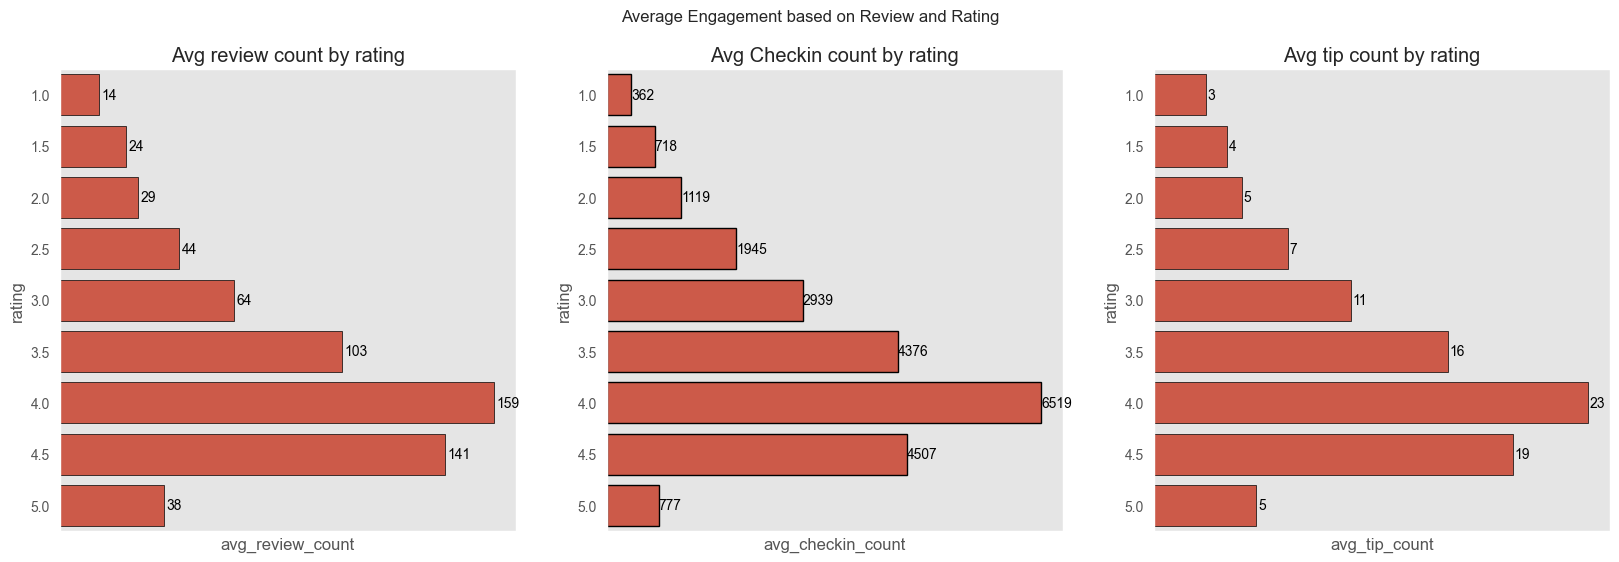

In [21]:
fig, ax = plt.subplots(1,3,figsize = (20,6))

#plot 1
sns.barplot(data=review_rating1, x='avg_review_count', y='rating', ax=ax[0], edgecolor = 'k')
for i, value in enumerate(review_rating1['avg_review_count']):
    ax[0].text(value+1, i, str(round(value)), color = 'black', va = 'center')
ax[0].set_xticks([])
ax[0].set_title('Avg review count by rating')

#plot 2
sns.barplot(data=review_rating1, x='avg_checkin_count', y='rating', ax=ax[1], edgecolor = 'k', linewidth = 1)
for i, value in enumerate(review_rating1['avg_checkin_count']):
    ax[1].text(value+2, i, str(round(value)), color = 'black', va = 'center')
ax[1].set_xticks([])
ax[1].set_title('Avg Checkin count by rating')

#plot 3
sns.barplot(data=review_rating1, x='avg_tip_count', y='rating', ax=ax[2], edgecolor = 'k')
for i, value in enumerate(review_rating1['avg_tip_count']):
    ax[2].text(value+0.1, i, str(round(value)), color = 'black', va = 'center')
ax[2].set_xticks([])
ax[2].set_title('Avg tip count by rating')

plt.suptitle('Average Engagement based on Review and Rating')
plt.show()

## Relation between review, tip and checkin

In [22]:
relation_ = pd.read_sql_query(f'''
    select b.business_id, sum(b.review_count) as review_count,
    avg(b.stars) as avg_rating,
    sum(length(cc.date) - length(replace(cc.date,',',''))+1) as checkin_count,
    sum(tip.tip_count) as tip_count
FROM
    business b
LEFT JOIN
    checkin cc on b.business_id = cc.business_id
LEFT JOIN
    (SELECT business_id, count(business_id) as tip_count from tip group by business_id order by tip_count) as tip
    on b.business_id = tip.business_id
    where b.business_id in {tuple(business_id['business_id'])}
    group by b.business_id
    ''', conn).dropna()

In [23]:
relation_[['review_count', 'tip_count', 'checkin_count']].corr().style.background_gradient()

,review_count,tip_count,checkin_count
review_count,1.000000,0.837101,0.807877
tip_count,0.837101,1.000000,0.905120
checkin_count,0.807877,0.905120,1.000000


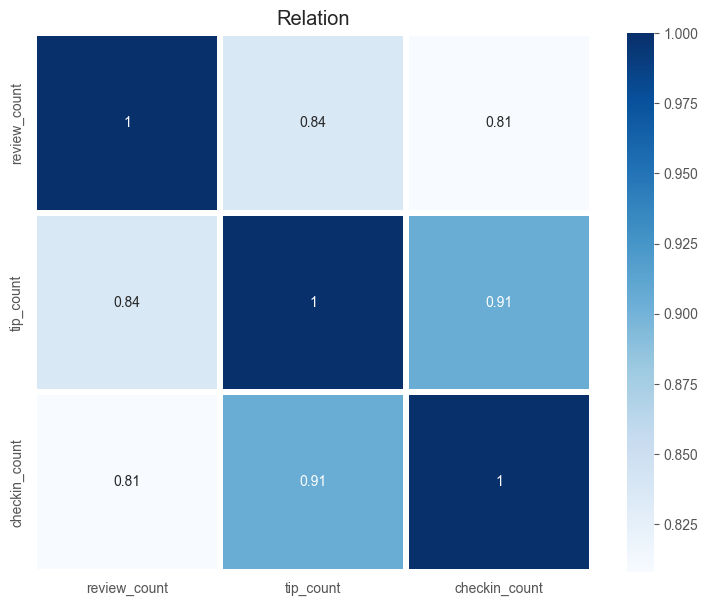

In [24]:
plt.figure(figsize = (9,7))
sns.heatmap(relation_[['review_count', 'tip_count', 'checkin_count']].corr(),cmap ='Blues', annot = True, linecolor='white', linewidths=3,cbar=True)
plt.title('Relation')
plt.show()

In [25]:
store_cat = pd.read_sql_query(f'''
    select b.business_id, sum(b.review_count) as review_count,
    avg(b.stars) as avg_rating,
    sum(length(cc.date) - length(replace(cc.date,',',''))+1) as checkin_count,
    sum(tip.tip_count) as tip_count,
    (CASE WHEN b.stars >=3.5 then 'High_Rated' ELSE 'Low_Rated' END ) as category
FROM
    business b
LEFT JOIN
    checkin cc on b.business_id = cc.business_id
LEFT JOIN
    (SELECT business_id, count(business_id) as tip_count from tip group by business_id order by tip_count) as tip
    on b.business_id = tip.business_id
    where b.business_id in {tuple(business_id['business_id'])}
    group by b.business_id
    ''', conn).dropna()

In [26]:
store_cat.groupby('category')[['review_count', 'tip_count', 'checkin_count']].mean()

,review_count,tip_count,checkin_count
category,,,
High_Rated,143.916814,19.260643,263.524127
Low_Rated,52.213997,7.772544,109.781758


In [27]:
def sucess_metric(df):
    sucess_score = []
    for index, row in df.iterrows():
        score = row['avg_rating'] * np.log(row['review_count']+1)
        sucess_score.append(score)
    return sucess_score

In [28]:
state_ = pd.read_sql_query(f''' SELECT city, state, latitude, longitude,
    SUM(review_count) as review_count,
    avg(stars) as avg_rating,
    count(*) as restaurant_open
    from business
    where business_id in {tuple(business_id['business_id'])}
    group by state, city
    order by review_count
    ''', conn).dropna()

In [29]:
state_['sucess_score'] = sucess_metric(state_)

## Map

In [30]:
m = folium.Map(
    location=[(state_['latitude'].mean()),(state_['longitude'].mean())], zoom_start=7,tiles="Cartodb Positron"
)
color_scale = folium.LinearColormap(colors = ['green','yellow','#E54F29'],
                                    vmin=state_['sucess_score'].min(), vmax=state_['sucess_score'].max()
                                   )
for index, row in state_.iterrows():
    folium.CircleMarker(
        location=[row['latitude'], row['longitude']], radius=10, fill = True, color = color_scale(row['sucess_score']), popup = f"Sucess Score: {row['sucess_score']}"
    ).add_to(m)
m.add_child(color_scale)

## Engagement Over Time

In [31]:
high_rated = pd.read_sql_query(f'''
select review.month_year, review.review_count, tip.tip_count from
    (select strftime('%m-%Y', date) as month_year, COUNT(*) AS review_count from review
    where business_id in {tuple(business_id['business_id'])} and stars >=3.5
    GROUP BY month_year
    ORDER BY month_year) as review
JOIN
    (select avg(b.stars), strftime('%m-%Y', tip.date) as month_year, count(*) as tip_count
    FROM tip
    join business b 
    on tip.business_id = b.business_id
    where tip.business_id in {tuple(business_id['business_id'])} and stars >=3.5
    GROUP BY month_year order by month_year) as tip
    on review.month_year = tip.month_year
''', conn)

low_rated = pd.read_sql_query(f'''
select review.month_year, review.review_count, tip.tip_count from
    (select strftime('%m-%Y', date) as month_year, COUNT(*) AS review_count from review
    where business_id in {tuple(business_id['business_id'])} and stars < 3.5
    GROUP BY month_year
    ORDER BY month_year) as review
JOIN
    (select avg(b.stars), strftime('%m-%Y', tip.date) as month_year, count(*) as tip_count
    FROM tip
    join business b 
    on tip.business_id = b.business_id
    where tip.business_id in {tuple(business_id['business_id'])} and stars < 3.5
    GROUP BY month_year order by month_year) as tip
    on review.month_year = tip.month_year
''', conn)

In [32]:
time_rating = pd.read_sql_query(f'''select strftime('%m-%Y',date) as month_year, avg(stars) as avg_rating from review where business_id in {tuple(business_id['business_id'])} group by month_year order by month_year''', conn)

In [33]:
time_rating['month_year'] = pd.to_datetime(time_rating['month_year'])
time_rating.sort_values('month_year', inplace = True)
time_rating = time_rating[time_rating['month_year'] > '2017']

high_rated['month_year'] = pd.to_datetime(high_rated['month_year'])
high_rated.sort_values('month_year', inplace = True)
high_rated = high_rated[high_rated['month_year'] > '2017']

low_rated['month_year'] = pd.to_datetime(low_rated['month_year'])
low_rated.sort_values('month_year', inplace = True)
low_rated = low_rated[low_rated['month_year'] > '2017']

In [34]:
high_rated['avg_rating'] = time_rating['avg_rating'].values

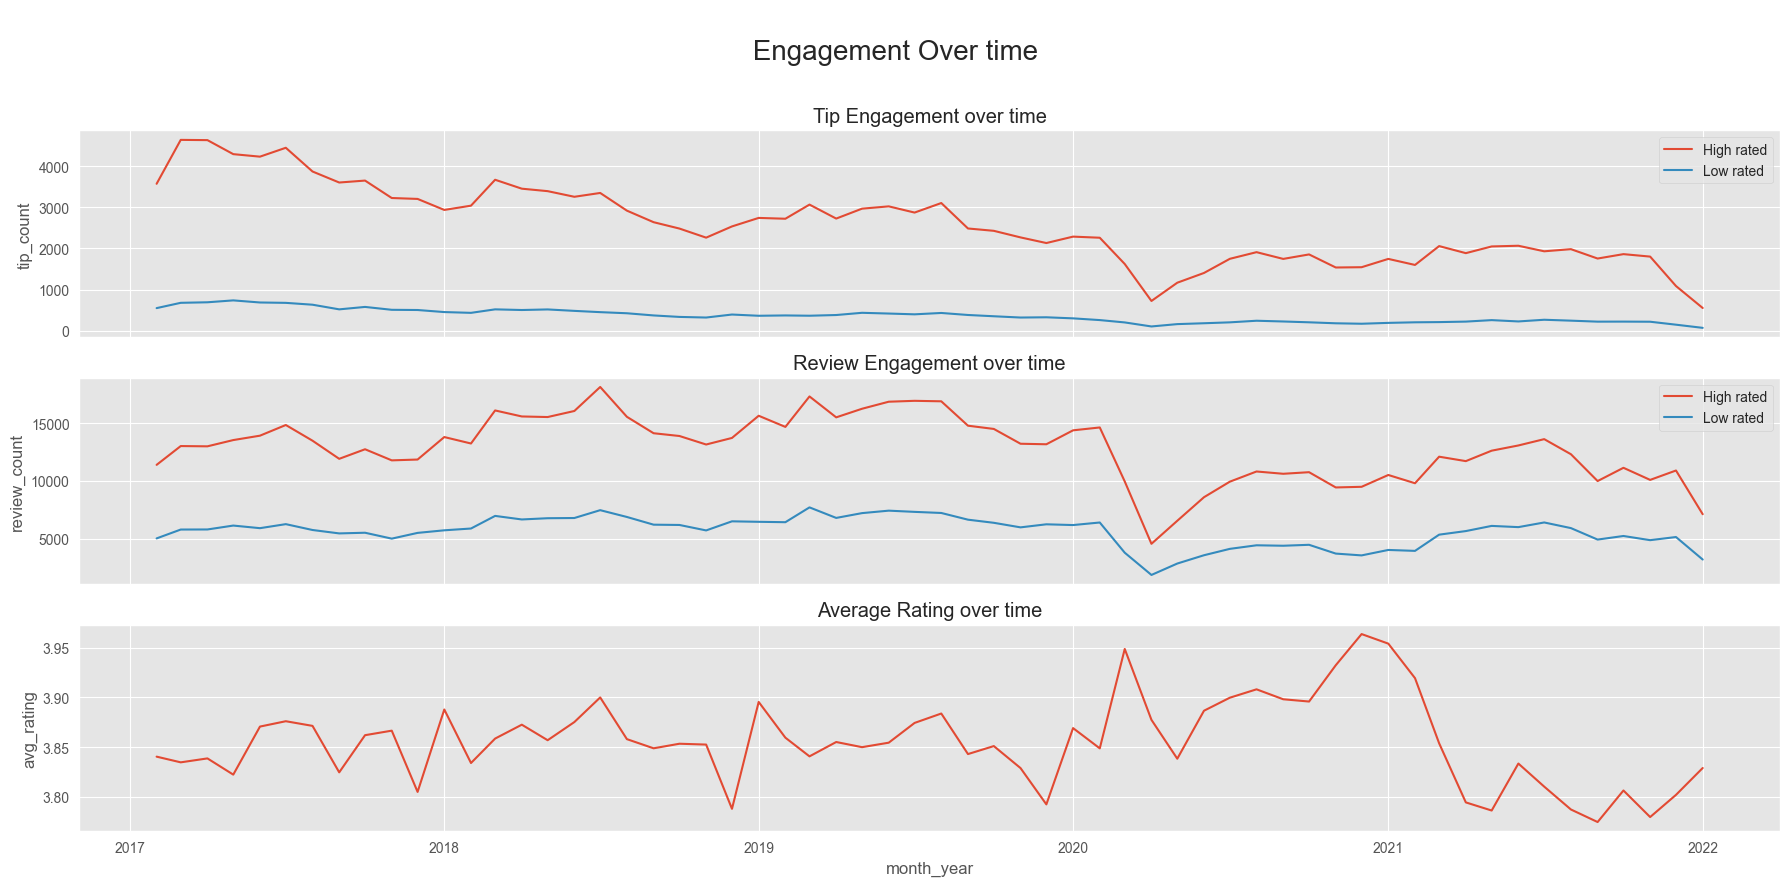

In [35]:
fig, ax = plt.subplots(3,1, figsize = (18,9
                                      ), sharex=True)

sns.lineplot(x = high_rated['month_year'], y = high_rated['tip_count'], label = 'High rated', ax = ax[0])
sns.lineplot(x = low_rated['month_year'], y = low_rated['tip_count'], label = 'Low rated', ax = ax[0])
ax[0].set_title('Tip Engagement over time')

sns.lineplot(x = high_rated['month_year'], y = high_rated['review_count'], label = 'High rated', ax = ax[1])
sns.lineplot(x = low_rated['month_year'], y = low_rated['review_count'], label = 'Low rated', ax = ax[1])
ax[1].set_title('Review Engagement over time')

sns.lineplot(x = time_rating['month_year'], y = time_rating['avg_rating'], ax = ax[2])
ax[2].set_title('Average Rating over time')

plt.suptitle('\n Engagement Over time \n ', fontsize = 20)
plt.grid(True)
plt.tight_layout()
plt.show()

## Seasonal Decompose

In [36]:
tip_df = high_rated[['month_year','tip_count']].set_index('month_year')
review_df = high_rated[['month_year','review_count']].set_index('month_year')
rating_df = time_rating[['month_year','avg_rating']].set_index('month_year')

In [37]:
from statsmodels.tsa.seasonal import seasonal_decompose

### Tip seasonal decompose

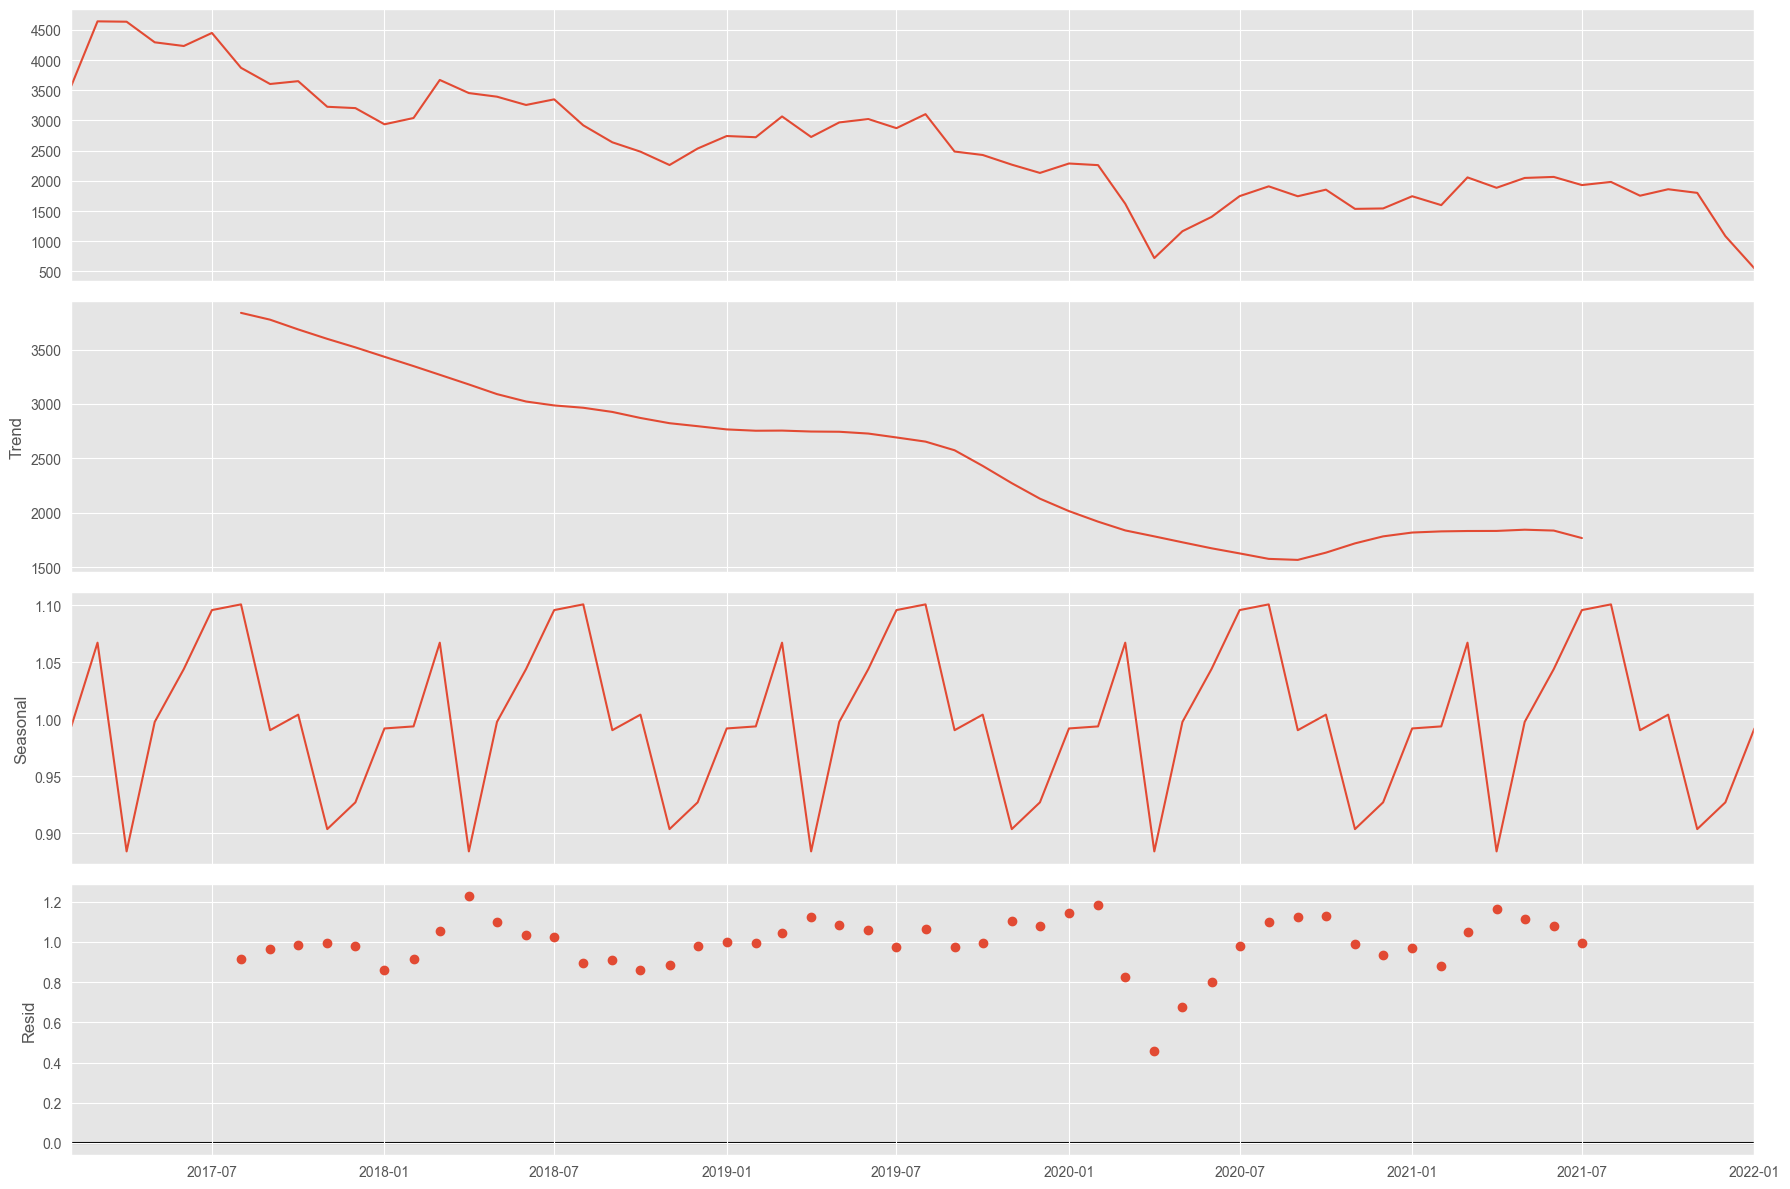

In [38]:
decompose = seasonal_decompose(tip_df, model='multiplicative', period=12)
plt.rcParams.update({'figure.figsize':(18,12)})
decompose.plot()
plt.show()

### Review Seasonal Decompose

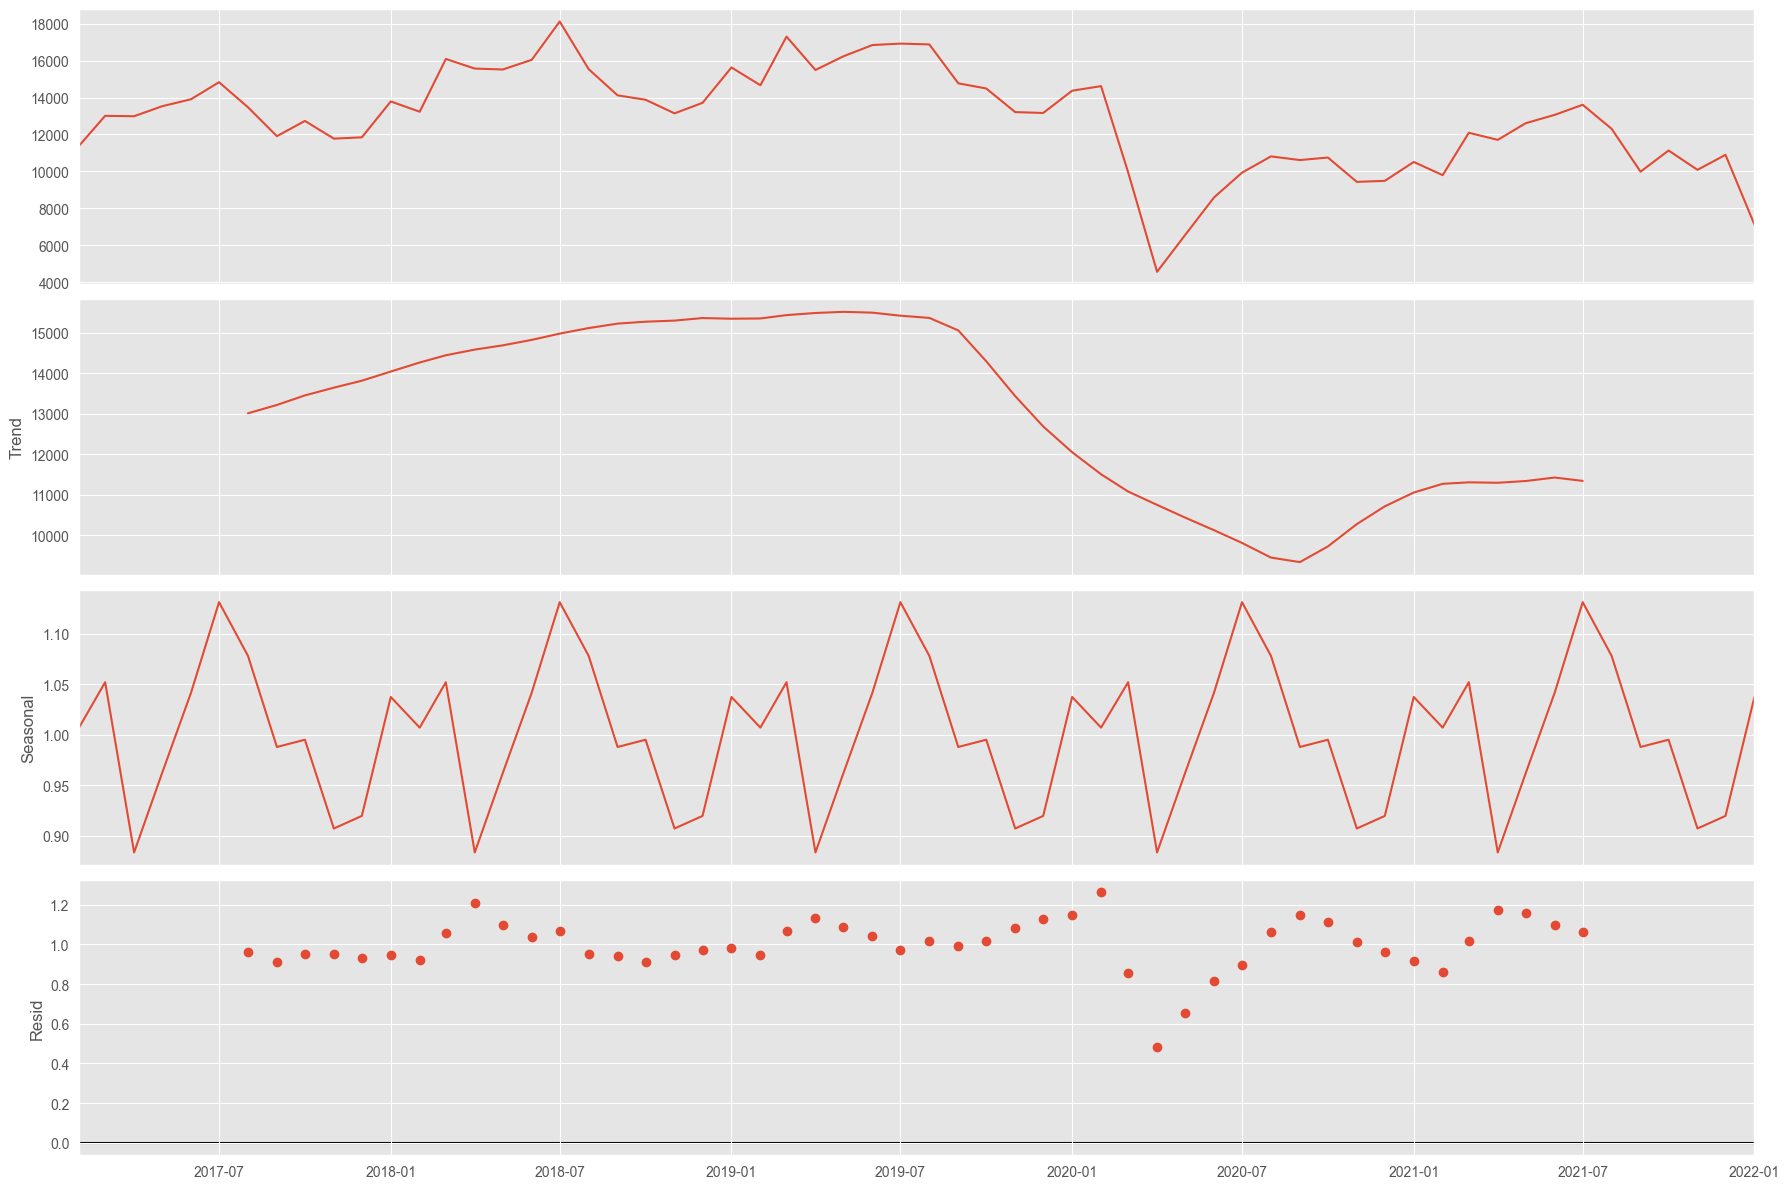

In [39]:
decompose = seasonal_decompose(review_df, model='multiplicative', period=12)
plt.rcParams.update({'figure.figsize':(18,12)})
decompose.plot()
plt.show()

### Rating seasonal decompose

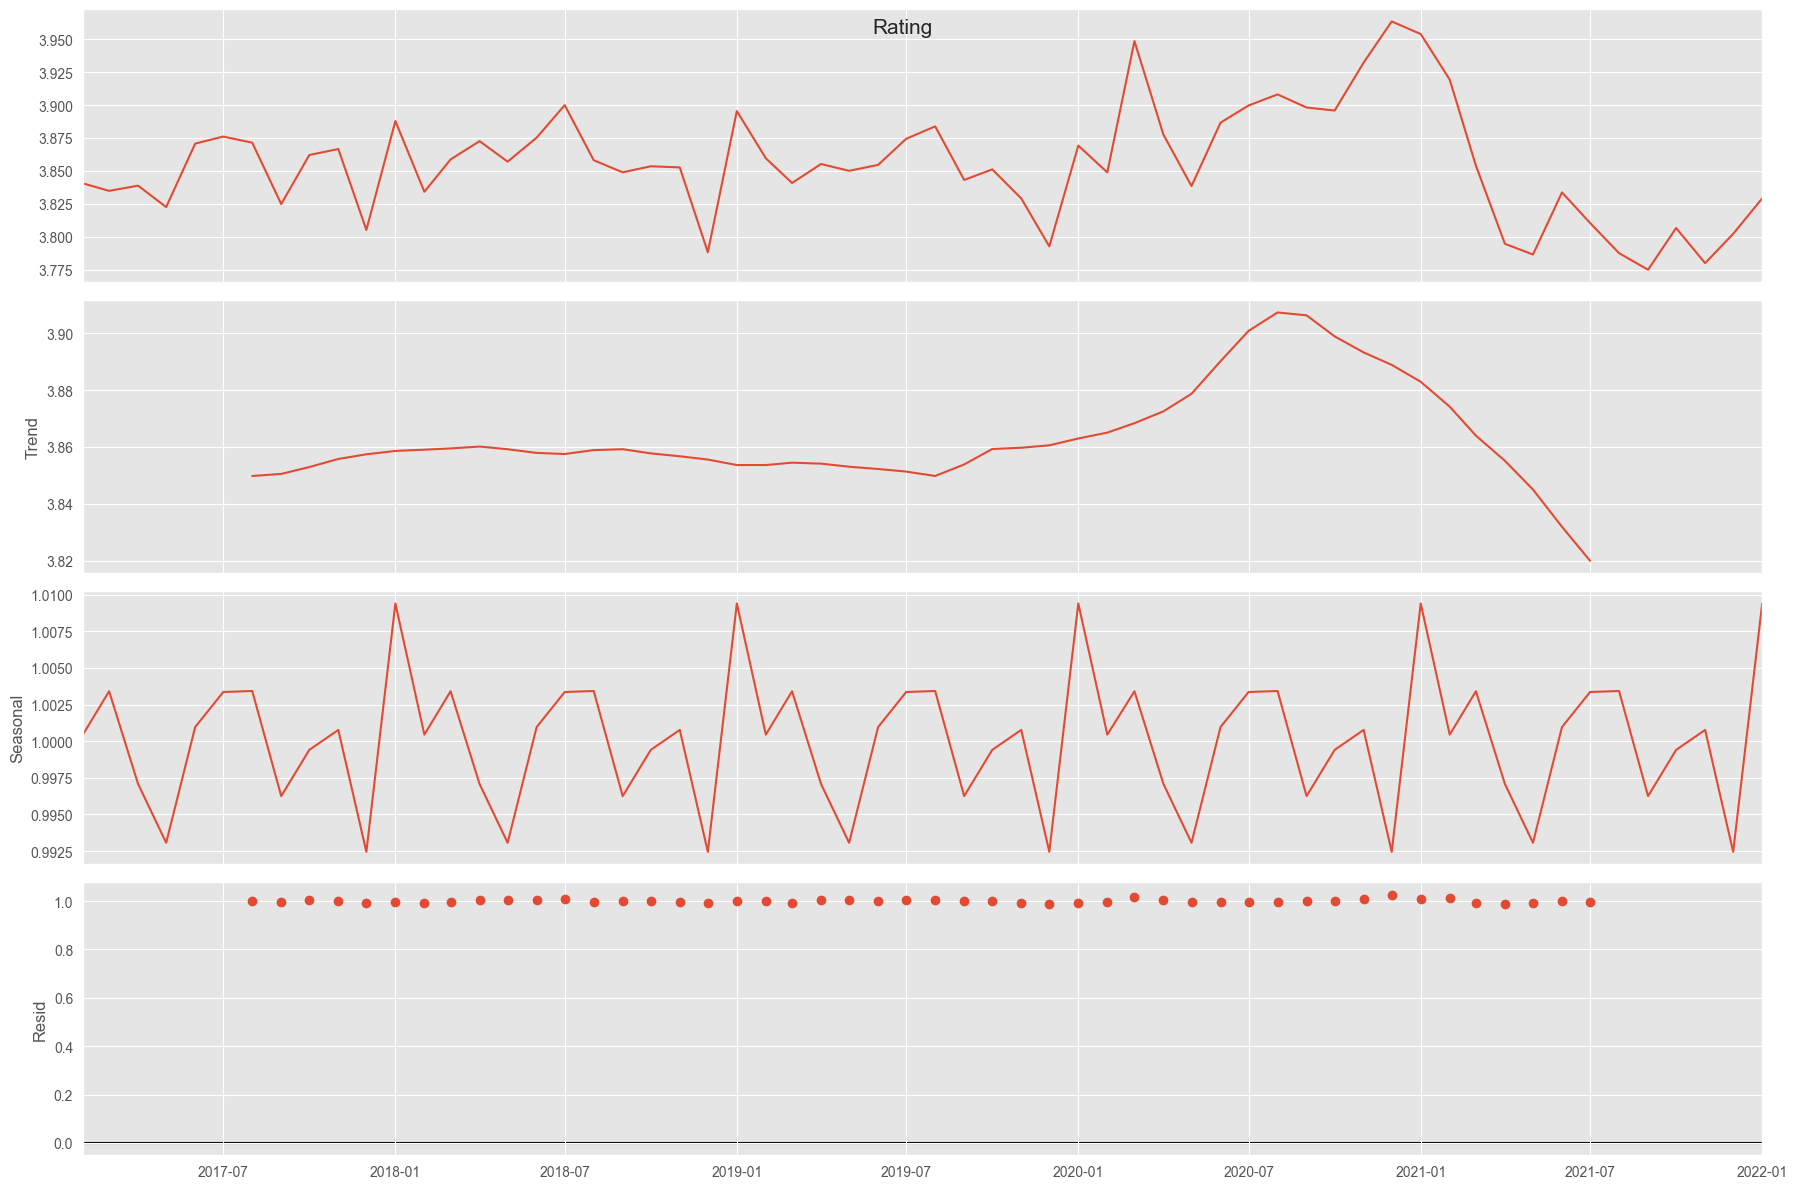

In [40]:
decompose = seasonal_decompose(rating_df, model='multiplicative', period=12)
plt.rcParams.update({'figure.figsize':(18,12)})
decompose.plot()
plt.suptitle('Rating', fontsize = 15)
plt.show()

## Sentiment Relationship

In [41]:
sentiment_ = pd.read_sql_query(f'''select b.business_id,avg(b.stars) as avg_rating, sum(b.review_count) as review_count,sum(useful) as useful_count, sum(funny) as funny_count, sum(cool) as cool_count from review
join business b on b.business_id = review.business_id
where b.business_id in {tuple(business_id['business_id'])}
group by b.business_id
''', conn)

In [42]:
sentiment_ = cape_outliers(sentiment_,['avg_rating', 'review_count', 'useful_count', 'funny_count',
       'cool_count'])

In [43]:
sentiment_['sucess_score']=sucess_metric(sentiment_)

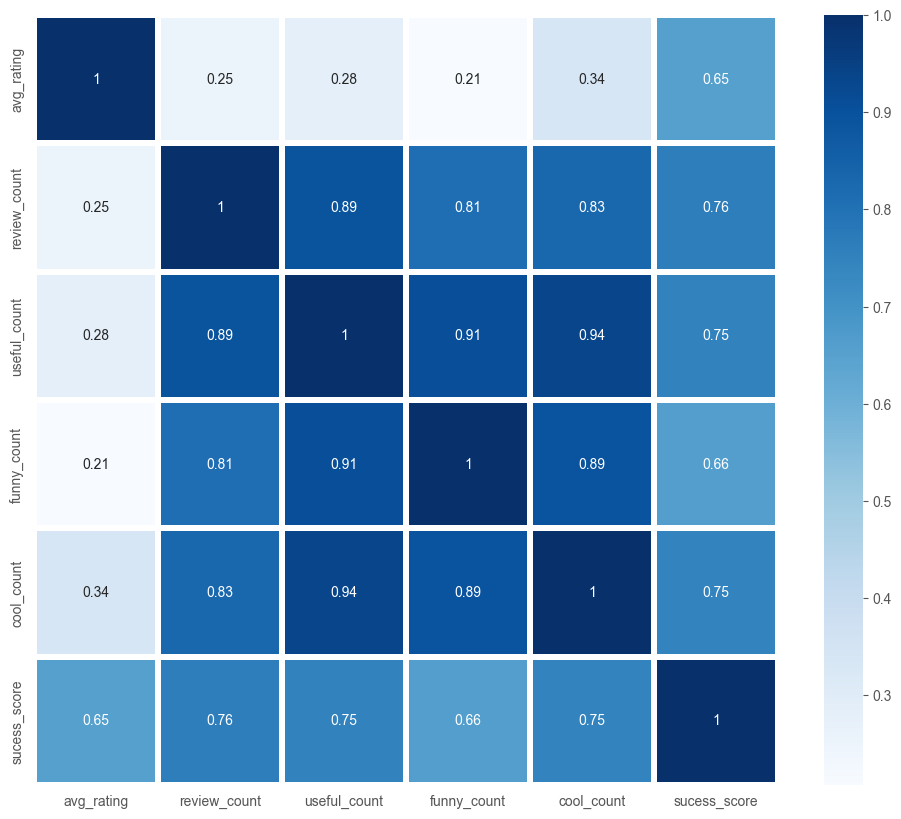

In [44]:
plt.figure(figsize = (12,10))
sns.heatmap(sentiment_.select_dtypes(exclude = 'object').corr(), cmap='Blues', annot=True, linecolor='white', linewidths=3)
plt.show()

## User Distribution

In [45]:
users = pd.read_sql_query('''SELECT 
    elite, count(*) as num_users, sum(review_count) as total_review
        from
    (select case when elite ='' then 'Non_elite' else 'Elite' end as elite, u.review_count from user u) as user_elite group by elite''', 
                  conn)

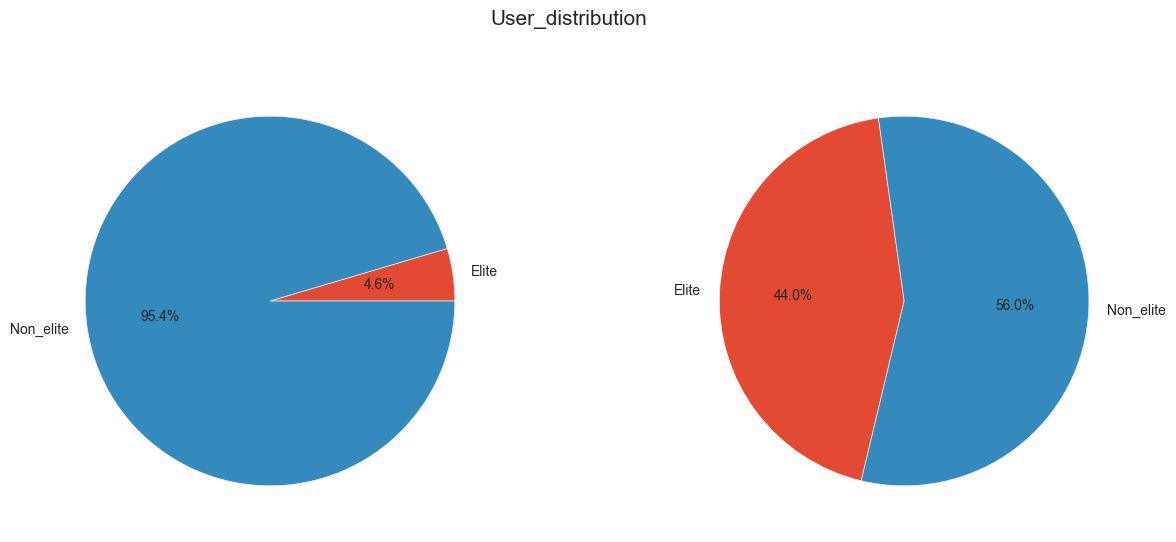

In [46]:
fig, ax = plt.subplots(1,2, figsize = (15,6))
ax[0].pie(users['num_users'], labels=users['elite'], autopct = '%.1f%%')
ax[1].pie(users['total_review'], labels=users['elite'], autopct = '%.1f%%', startangle = 98)
plt.suptitle('User_distribution', fontsize = 15)
plt.show()

From the visuals, Non elite users are more than elite users on yelp, but the review given is given by elite users are comparatively higher the non elite users.

## Most Engagement in Day

In [47]:
review_ = pd.read_sql_query('''SELECT cast (strftime('%H',date) as integer) as hour, count(*) as review_count from review group by hour''', conn)

In [48]:
tip_ = pd.read_sql_query('''SELECT cast (strftime('%H',date) as integer) as hour, count(*) as tip_count from tip group by hour''', conn)

In [49]:
checkin_ = pd.read_sql_query('''select date from checkin''', conn)
checkin_engage = []
for i in checkin_['date']:
    checkin_engage.extend([datetime.strptime(j.strip(), "%Y-%m-%d %H:%M:%S").strftime('%H') for j in i.split(',')])

In [50]:
checkin_engage = pd.DataFrame(checkin_engage).astype('int').groupby(0)[[0]].count()

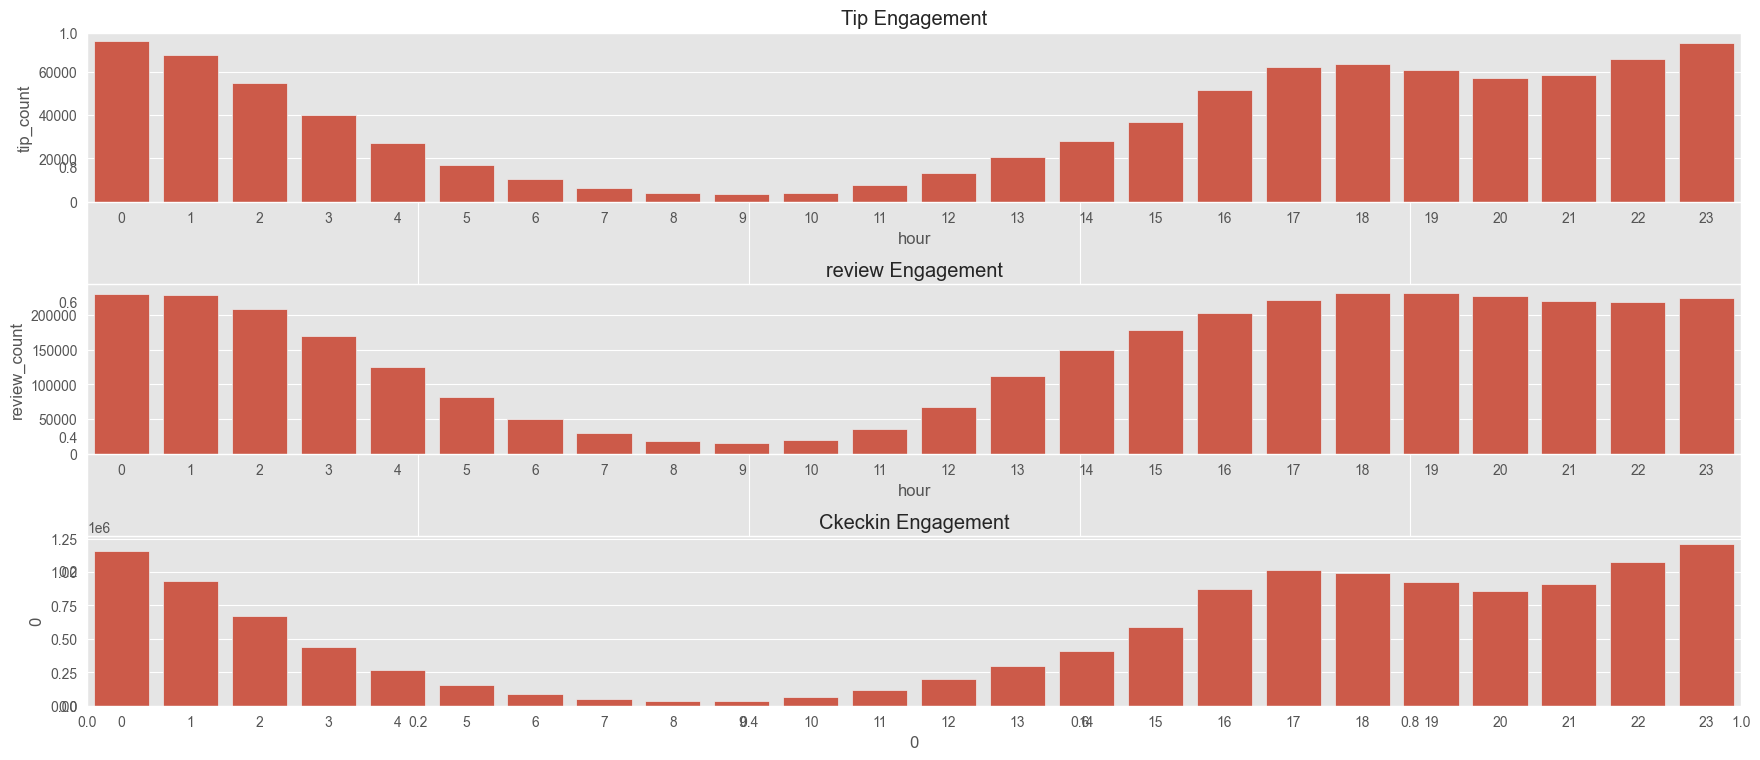

In [51]:
plt.subplots(figsize = (18,8), sharex=True)

plt.subplot(3,1,1)
plt.title('Tip Engagement')
sns.barplot(data = tip_, x = 'hour', y = 'tip_count')

plt.subplot(3,1,2)
plt.title('review Engagement')
sns.barplot(data = review_, x = 'hour', y = 'review_count')

plt.subplot(3,1,3)
plt.title('Ckeckin Engagement')
sns.barplot(data = checkin_engage, x = checkin_engage.index, y = checkin_engage[0])
plt.tight_layout()
plt.show()

there is downward trend in morning, from 12 there is slight uptrend to whole night. This means people visit restuarant lot higher in evening and night time as compared to day time. morning 7,8 and 9 have the lowest checkin. 